In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

In [ ]:
dataset_path = '/content/drive/MyDrive/dl miniproject/16000_pcm_speeches'
speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

In [ ]:
def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

In [ ]:
X, y = extract_features(dataset_path, speaker_folders)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
bigru_model = models.Sequential([
    layers.Bidirectional(layers.GRU(128), input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(speaker_folders), activation='softmax')
])

In [ ]:
bigru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
bigru_history = bigru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
165/165 [==============================] - 16s 71ms/step - loss: 0.2458 - accuracy: 0.9184 - val_loss: 0.0575 - val_accuracy: 0.9840
Epoch 2/20
165/165 [==============================] - 8s 50ms/step - loss: 0.0275 - accuracy: 0.9943 - val_loss: 0.0301 - val_accuracy: 0.9894
Epoch 3/20
165/165 [==============================] - 10s 63ms/step - loss: 0.0112 - accuracy: 0.9983 - val_loss: 0.0272 - val_accuracy: 0.9894
Epoch 4/20
165/165 [==============================] - 11s 64ms/step - loss: 0.0037 - accuracy: 0.9998 - val_loss: 0.0206 - val_accuracy: 0.9920
Epoch 5/20
165/165 [==============================] - 8s 50ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.0161 - val_accuracy: 0.9920
Epoch 6/20
165/165 [==============================] - 13s 79ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0155 - val_accuracy: 0.9929
Epoch 7/20
165/165 [==============================] - 11s 67ms/step - loss: 6.9002e-04 - accuracy: 1.0000 - val_loss: 0.0136 - val_accurac

In [ ]:
bigru_y_pred_probabilities = bigru_model.predict(X_test)
bigru_y_pred = np.argmax(bigru_y_pred_probabilities, axis=1)
bigru_accuracy = accuracy_score(y_test, bigru_y_pred)
bigru_f1 = f1_score(y_test, bigru_y_pred, average='weighted')

36/36 [==============================] - 2s 20ms/step


In [ ]:
print(f"BiGRU Model Test Accuracy: {bigru_accuracy}")
print(f"BiGRU Model Weighted F1 Score: {bigru_f1}")

BiGRU Model Test Accuracy: 1.0
BiGRU Model Weighted F1 Score: 1.0


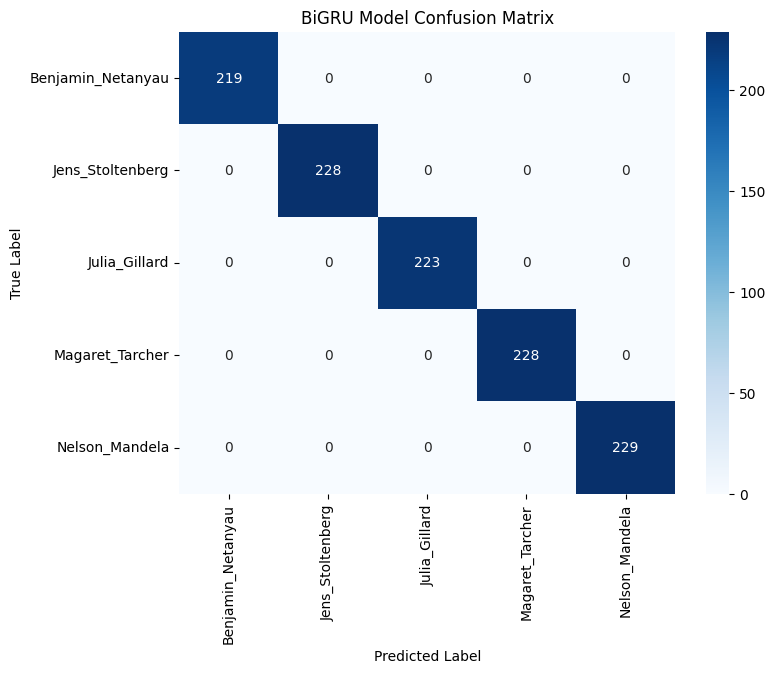

In [ ]:
bigru_conf_matrix = confusion_matrix(y_test, bigru_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(bigru_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)
plt.title("BiGRU Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

                   precision    recall  f1-score   support

Benjamin_Netanyau       1.00      1.00      1.00       219
 Jens_Stoltenberg       1.00      1.00      1.00       228
    Julia_Gillard       1.00      1.00      1.00       223
  Magaret_Tarcher       1.00      1.00      1.00       228
   Nelson_Mandela       1.00      1.00      1.00       229

         accuracy                           1.00      1127
        macro avg       1.00      1.00      1.00      1127
     weighted avg       1.00      1.00      1.00      1127



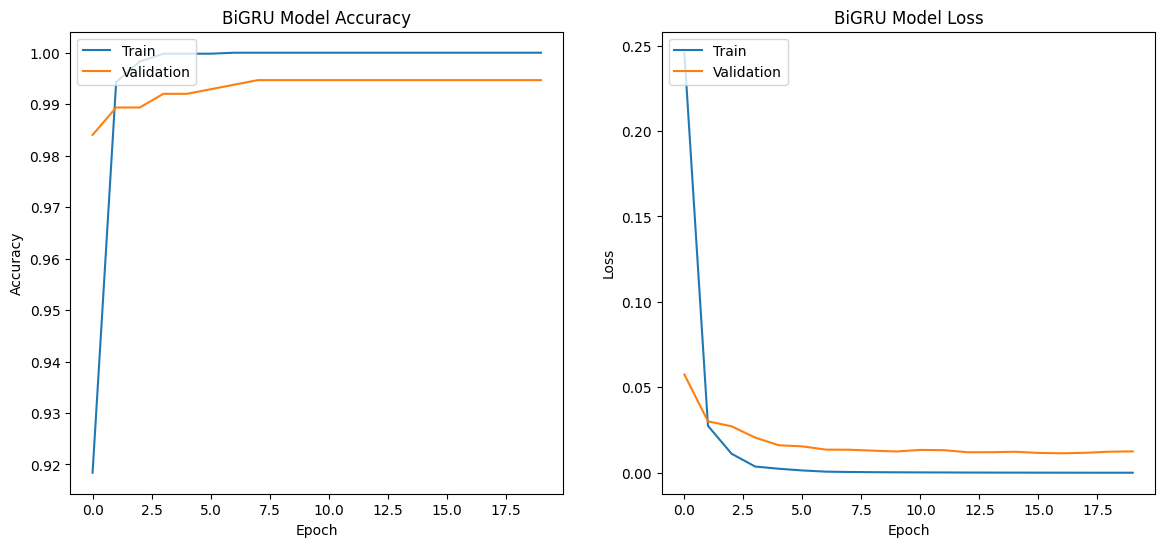

In [ ]:
from sklearn.metrics import classification_report

# Assuming y_test, bigru_y_pred, bigru_history, and speaker_folders are already defined
# Generate the classification report
report = classification_report(y_test, bigru_y_pred, target_names=speaker_folders)
print(report)

# Plot training and validation accuracy and loss over epochs
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(bigru_history.history['accuracy'])
plt.plot(bigru_history.history['val_accuracy'])
plt.title('BiGRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(bigru_history.history['loss'])
plt.plot(bigru_history.history['val_loss'])
plt.title('BiGRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
